In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
from train import get_args, load_model, ForegroundMaskTarget, CentroidMaskTarget
import datasets as raft_datasets
import utils.flow_viz as flow_viz

def set_args(args_dict={}):
    args = get_args("")
    for k,v in args_dict.items():
        args.__setattr__(k, v)
    return args

def tensor_to_arr(tensor, ex=0):
    if len(tensor.shape) == 4:
        tensor = tensor[ex]
    return tensor.detach().permute(1, 2, 0).cpu().numpy()

def viz(tensor, ex=0):
    im = tensor_to_arr(tensor, ex)
    if im.max() > 2.0:
        im = im / 255.0
    plt.imshow(im)
    

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Davis Dataset

In [6]:
dataset = raft_datasets.DavisFlowDataset(
    get_gt_flow=True, split='all', resize=(270, 480), flow_gap=1, 
    min_start_frame=0, max_start_frame=None,
    get_segments=True,
    get_flow_images=True
)

odict_keys(['bear', 'blackswan', 'bmx-bumps', 'bmx-trees', 'boat', 'breakdance', 'breakdance-flare', 'bus', 'camel', 'car-roundabout', 'car-shadow', 'car-turn', 'cows', 'dance-jump', 'dance-twirl', 'dog', 'dog-agility', 'drift-chicane', 'drift-straight', 'drift-turn', 'elephant', 'flamingo', 'goat', 'hike', 'hockey', 'horsejump-high', 'horsejump-low', 'kite-surf', 'kite-walk', 'libby', 'lucia', 'mallard-fly', 'mallard-water', 'motocross-bumps', 'motocross-jump', 'motorbike', 'paragliding', 'paragliding-launch', 'parkour', 'rhino', 'rollerblade', 'scooter-black', 'scooter-gray', 'soapbox', 'soccerball', 'stroller', 'surf', 'swing', 'tennis', 'train'])


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Target model for subtracting flow background

In [7]:
target_net = nn.DataParallel(ForegroundMaskTarget(
    resolution=8,
    num_masks=32,
    get_connected_component=True,
    mask_input=False)).cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
ex = 'elephant'
data_blob = dataset[ex]
image1, image2, flow = [x[None].cuda() for x in data_blob]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
mask = target_net(flow)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/dbear/tenv/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [13]:
mask.shape

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([1, 1, 264, 480])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


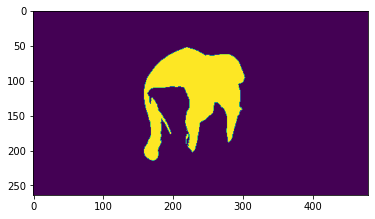

In [14]:
viz(mask)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


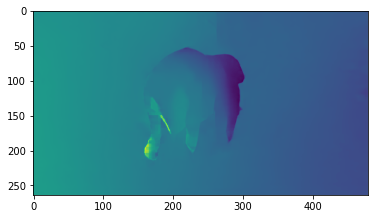

In [15]:
viz(flow[:,1:2])

## Look at some models

In [16]:
thing_net = load_model('../checkpoints/90000_thingness-davis-selfsup-ccs-bs4.pth',
                 train=True, cuda=True, small=False, freeze_bn=False, gpus=[0])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully>


In [17]:
cent_net = load_model('../checkpoints/90000_centroid-davis-selfsup-ccs-bs4.pth',
                 train=True, cuda=True, small=False, freeze_bn=False, gpus=[0])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully>


In [18]:
import bootraft
kpnet = bootraft.KpPrior(
    cent_net, thing_net, normalize_coordinates=True, randomize_background=True, resolution=8, 
    thingness_thresh=0.5, norm_p=2.0
).cuda()

target_net = nn.DataParallel(ForegroundMaskTarget(
    resolution=8,
    num_masks=32,
    get_connected_component=True,
    mask_input=False)).cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
from pathlib import Path
print([Path(d).name for d in dataset.dataset_names])

['bear', 'blackswan', 'bmx-bumps', 'bmx-trees', 'boat', 'breakdance', 'breakdance-flare', 'bus', 'camel', 'car-roundabout', 'car-shadow', 'car-turn', 'cows', 'dance-jump', 'dance-twirl', 'dog', 'dog-agility', 'drift-chicane', 'drift-straight', 'drift-turn', 'elephant', 'flamingo', 'goat', 'hike', 'hockey', 'horsejump-high', 'horsejump-low', 'kite-surf', 'kite-walk', 'libby', 'lucia', 'mallard-fly', 'mallard-water', 'motocross-bumps', 'motocross-jump', 'motorbike', 'paragliding', 'paragliding-launch', 'parkour', 'rhino', 'rollerblade', 'scooter-black', 'scooter-gray', 'soapbox', 'soccerball', 'stroller', 'surf', 'swing', 'tennis', 'train']


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
target_net.module.Compete

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Competition()

In [33]:
kp_prior.shape

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([1, 64, 264, 480])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([1, 264, 480, 32])


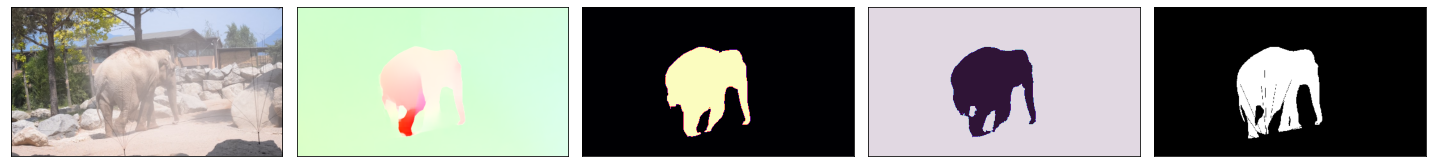

In [197]:
import os
save_dir = '/mnt/fs6/dbear/eccv_2022_results/figures/davis_motion'
ex = 'elephant'
filename = ex + '_' + str(it)

do_save = True

thresh = 0.5
img1, img2, flow = dataset[ex]
gt = dataset.gt
kp_prior = kpnet(img1.cuda()[None], img1.cuda()[None], test_mode=True)
_, thing = thing_net(img1.cuda()[None], img1.cuda()[None], iters=24, test_mode=True)
mask = (torch.sigmoid(thing) > thresh).float().detach().cpu().numpy()[0,0]

h0 = kp_prior[0].max(-3)[1].detach().cpu().numpy()
target = target_net(flow[None].cuda())
pred = target_net.module.Compete(kp_prior.permute(0,2,3,1))[0]

print(pred.shape)
# flow_img = FlowToRgb(max_speed=10.0)(flow)
flow_img = flow_viz.flow_to_image(tensor_to_arr(flow))
fig, axes = plt.subplots(1,5,figsize=(20,4))
axes[0].imshow(tensor_to_arr(img1 / 255.))
axes[1].imshow(flow_img)
# axes[3].imshow(h0 * (mask[...,None] if len(h0.shape) == 3 else mask), cmap='twilight')
axes[2].imshow(tensor_to_arr(target), cmap='magma')
axes[3].imshow(mask, cmap='twilight', vmax=2)
# axes[3].imshow(pred.argmax(-1)[0].detach().cpu().numpy(), cmap='twilight', vmax=pred.argmax(-1).amax().item()+1)

axes[4].imshow(tensor_to_arr(gt))

titles = ['image', 'RAFT flow', 'motion segment', 'kp prior (static)', 'gt segment']
for i,ax in enumerate(axes):
    ax.set_xticks([])
    ax.set_yticks([])
    if not do_save:
        ax.set_title(titles[i], fontsize=20)
plt.tight_layout()

if do_save:
    plt.savefig(os.path.join(save_dir, filename)+'.svg', transparent=True, format='svg')
    it += 1
plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


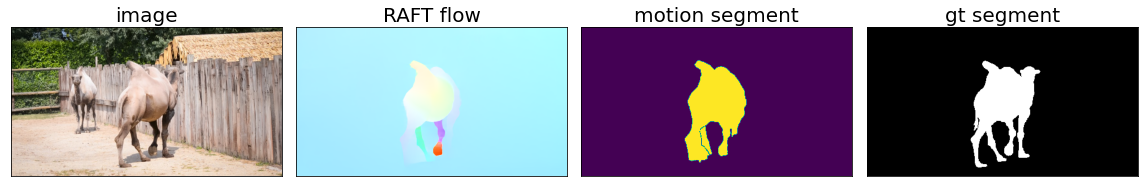

In [54]:
ex = 'camel'
thresh = 0.5
img1, img2, flow = dataset[ex]
gt = dataset.gt

target = target_net(flow[None].cuda())

flow_img = flow_viz.flow_to_image(tensor_to_arr(flow))
fig, axes = plt.subplots(1,4,figsize=(16,4))
axes[0].imshow(tensor_to_arr(img1 / 255.))
axes[1].imshow(flow_img)
axes[2].imshow(tensor_to_arr(target))
axes[3].imshow(tensor_to_arr(gt))

titles = ['image', 'RAFT flow', 'motion segment', 'gt segment']
for i,ax in enumerate(axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], fontsize=20)
plt.tight_layout()
plt.show()

## Compute metrics

In [375]:
from tqdm import tqdm
from collections import OrderedDict

def iou(pred, gt, eps=1e-3):
    assert pred.shape == gt.shape, (pred.shape, gt.shape)
    pred, gt = (pred > 0.5).float(), (gt > 0.5).float()
    intersection = (pred * gt).sum()
    union = (pred + gt).clamp(max=1.0).sum()
    return (intersection / (union + eps)).item()

def get_thingness_iou(net, vid_dataset, ex='camel', size=None, frame = 0, iters=12, thresh=0.5):

    if size is not None:
        vid_dataset.resize_to = size

    vid_dataset.min_start_frame = vid_dataset.max_start_frame = frame
    img1, img2, _ = vid_dataset[ex]
    gt = vid_dataset.gt[0:1].cuda()
    gt = (gt[:,0:1] > 0.5).float()
    pred = net(img1[None].cuda(), img1[None].cuda(), iters=iters, test_mode=True)[-1]
    pred = (torch.sigmoid(pred) > thresh).float()
    
    return iou(pred, gt)

def get_selfsup_iou(net, vid_dataset, ex='camel', size=None, frame = 0, iters=12, **kwargs):
    
    if size is not None:
        vid_dataset.resize_to = size
    vid_dataset.min_start_frame = vid_dataset.max_start_frame = frame
    img1, img2, flow = vid_dataset[ex]
    gt = vid_dataset.gt[0:1].cuda()
    gt = (gt[:,0:1] > 0.5).float()
    target = net(flow[None].cuda()).float()
    
    return iou(target, gt)
    
def get_sequence_iou(net, vid_dataset, ex='camel',
                     eval_func=get_thingness_iou,
                     frame_start=0, frame_end=None, 
                     **kwargs):
    
    if isinstance(ex, int):
        seq_nm = sorted(vid_dataset.files.keys())[ex]
    elif ex not in vid_dataset.files.keys():
        raise ValueError("%s isn't one of the sequences in the %s split" % (str(ex), vid_dataset.split))
    else:
        seq_nm = ex
    num_frames = len(vid_dataset.files[seq_nm])

    frame_ious = OrderedDict()
    for frame in tqdm(range(frame_start, frame_end or num_frames)):
        frame_ious[frame] = eval_func(net, vid_dataset, ex=seq_nm, frame=frame, **kwargs)
        
    return frame_ious, np.mean(list(frame_ious.values()))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [400]:
# get_selfsup_iou(target_net, dataset, ex='camel', frame=0)
get_sequence_iou(target_net, dataset, ex='camel', eval_func=get_selfsup_iou, frame_end=2)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 2/2 [00:00<00:00,  3.03it/s]


(OrderedDict([(0, 0.9350228905677795), (1, 0.9364449977874756)]),
 0.9357339441776276)

In [370]:
# mean_results = OrderedDict()
# per_frame_results = OrderedDict()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [401]:
# mean_target_results = OrderedDict()
# per_frame_target_results = OrderedDict()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [404]:
for seq_nm in dataset.files.keys():
    if seq_nm in mean_target_results.keys():
        print("skipping %s, already done" % seq_nm)
        continue
    ious, mean_iou = get_sequence_iou(target_net, dataset, ex=seq_nm, frame_start=0, frame_end=None,
                                      eval_func=get_selfsup_iou
                                     )
    mean_target_results[seq_nm] = mean_iou
    per_frame_target_results[seq_nm] = ious
    print("%s mean iou across %d frames ---- %.3f" % (seq_nm, len(list(ious.keys())), mean_iou))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/50 [00:00<?, ?it/s]

bear mean iou across 82 frames ---- 0.311


  0%|          | 0/90 [00:00<?, ?it/s]

blackswan mean iou across 50 frames ---- 0.238


  0%|          | 0/80 [00:00<?, ?it/s]

bmx-bumps mean iou across 90 frames ---- 0.233


  0%|          | 0/75 [00:00<?, ?it/s]

bmx-trees mean iou across 80 frames ---- 0.335


  0%|          | 0/84 [00:00<?, ?it/s]

boat mean iou across 75 frames ---- 0.053


  0%|          | 0/71 [00:00<?, ?it/s]

breakdance mean iou across 84 frames ---- 0.652


  0%|          | 0/80 [00:00<?, ?it/s]

breakdance-flare mean iou across 71 frames ---- 0.623


  0%|          | 0/90 [00:00<?, ?it/s]

bus mean iou across 80 frames ---- 0.468


  0%|          | 0/75 [00:00<?, ?it/s]

camel mean iou across 90 frames ---- 0.772


  0%|          | 0/40 [00:00<?, ?it/s]

car-roundabout mean iou across 75 frames ---- 0.627


  0%|          | 0/80 [00:00<?, ?it/s]

car-shadow mean iou across 40 frames ---- 0.355


  0%|          | 0/104 [00:00<?, ?it/s]

car-turn mean iou across 80 frames ---- 0.378


  0%|          | 0/60 [00:00<?, ?it/s]

cows mean iou across 104 frames ---- 0.565


  0%|          | 0/90 [00:00<?, ?it/s]

dance-jump mean iou across 60 frames ---- 0.484


  0%|          | 0/60 [00:00<?, ?it/s]

dance-twirl mean iou across 90 frames ---- 0.554


  0%|          | 0/25 [00:00<?, ?it/s]

dog mean iou across 60 frames ---- 0.209


  0%|          | 0/52 [00:00<?, ?it/s]

dog-agility mean iou across 25 frames ---- 0.288


  0%|          | 0/50 [00:00<?, ?it/s]

drift-chicane mean iou across 52 frames ---- 0.574


  0%|          | 0/64 [00:00<?, ?it/s]

drift-straight mean iou across 50 frames ---- 0.196


  0%|          | 0/80 [00:00<?, ?it/s]

drift-turn mean iou across 64 frames ---- 0.444


  0%|          | 0/80 [00:00<?, ?it/s]

elephant mean iou across 80 frames ---- 0.524


  0%|          | 0/90 [00:00<?, ?it/s]

flamingo mean iou across 80 frames ---- 0.361


  0%|          | 0/80 [00:00<?, ?it/s]

goat mean iou across 90 frames ---- 0.100


  0%|          | 0/75 [00:00<?, ?it/s]

hike mean iou across 80 frames ---- 0.402


  0%|          | 0/50 [00:00<?, ?it/s]

hockey mean iou across 75 frames ---- 0.479


  0%|          | 0/60 [00:00<?, ?it/s]

horsejump-high mean iou across 50 frames ---- 0.503


  0%|          | 0/50 [00:00<?, ?it/s]

horsejump-low mean iou across 60 frames ---- 0.611


  0%|          | 0/80 [00:00<?, ?it/s]

kite-surf mean iou across 50 frames ---- 0.159


  0%|          | 0/49 [00:00<?, ?it/s]

kite-walk mean iou across 80 frames ---- 0.419


  0%|          | 0/70 [00:00<?, ?it/s]

libby mean iou across 49 frames ---- 0.135


  0%|          | 0/70 [00:00<?, ?it/s]

lucia mean iou across 70 frames ---- 0.603


  0%|          | 0/80 [00:00<?, ?it/s]

mallard-fly mean iou across 70 frames ---- 0.366


  0%|          | 0/60 [00:00<?, ?it/s]

mallard-water mean iou across 80 frames ---- 0.065


  0%|          | 0/40 [00:00<?, ?it/s]

motocross-bumps mean iou across 60 frames ---- 0.627


  0%|          | 0/43 [00:00<?, ?it/s]

motocross-jump mean iou across 40 frames ---- 0.543


  0%|          | 0/70 [00:00<?, ?it/s]

motorbike mean iou across 43 frames ---- 0.211


  0%|          | 0/80 [00:00<?, ?it/s]

paragliding mean iou across 70 frames ---- 0.525


  0%|          | 0/100 [00:00<?, ?it/s]

paragliding-launch mean iou across 80 frames ---- 0.489


  0%|          | 0/90 [00:00<?, ?it/s]

parkour mean iou across 100 frames ---- 0.306


  0%|          | 0/35 [00:00<?, ?it/s]

rhino mean iou across 90 frames ---- 0.650


  0%|          | 0/43 [00:00<?, ?it/s]

rollerblade mean iou across 35 frames ---- 0.544


  0%|          | 0/75 [00:00<?, ?it/s]

scooter-black mean iou across 43 frames ---- 0.312


  0%|          | 0/99 [00:00<?, ?it/s]

scooter-gray mean iou across 75 frames ---- 0.328


  0%|          | 0/48 [00:00<?, ?it/s]

soapbox mean iou across 99 frames ---- 0.392


  0%|          | 0/91 [00:00<?, ?it/s]

soccerball mean iou across 48 frames ---- 0.875


  0%|          | 0/55 [00:00<?, ?it/s]

stroller mean iou across 91 frames ---- 0.180


  0%|          | 0/60 [00:00<?, ?it/s]

surf mean iou across 55 frames ---- 0.273


  0%|          | 0/70 [00:00<?, ?it/s]

swing mean iou across 60 frames ---- 0.452


  0%|          | 0/80 [00:00<?, ?it/s]

tennis mean iou across 70 frames ---- 0.681


100%|██████████| 80/80 [00:22<00:00,  3.51it/s]

train mean iou across 80 frames ---- 0.346


In [374]:
for seq_nm in dataset.files.keys():
    if seq_nm in mean_results.keys():
        print("skipping %s, already done" % seq_nm)
        continue
    ious, mean_iou = get_sequence_iou(thing_net, dataset, ex=seq_nm, frame_start=0, frame_end=None)
    mean_results[seq_nm] = mean_iou
    per_frame_results[seq_nm] = ious
    print("%s mean iou across %d frames ---- %.3f" % (seq_nm, len(list(ious.keys())), mean_iou))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  2%|▏         | 1/50 [00:00<00:09,  5.28it/s]

skipping bear, already done


  1%|          | 1/90 [00:00<00:12,  7.22it/s]

blackswan mean iou across 50 frames ---- 0.281


  1%|▏         | 1/80 [00:00<00:08,  8.95it/s]

bmx-bumps mean iou across 90 frames ---- 0.422


  3%|▎         | 2/75 [00:00<00:07, 10.34it/s]

bmx-trees mean iou across 80 frames ---- 0.314


  1%|          | 1/84 [00:00<00:13,  6.35it/s]

boat mean iou across 75 frames ---- 0.031


  1%|▏         | 1/71 [00:00<00:09,  7.08it/s]

breakdance mean iou across 84 frames ---- 0.626


  1%|▏         | 1/80 [00:00<00:10,  7.76it/s]

breakdance-flare mean iou across 71 frames ---- 0.628


  1%|▏         | 1/75 [00:00<00:10,  6.97it/s]

bus mean iou across 80 frames ---- 0.738
skipping camel, already done


  1%|▏         | 1/80 [00:00<00:09,  8.61it/s]

car-roundabout mean iou across 75 frames ---- 0.706
skipping car-shadow, already done


  2%|▏         | 1/60 [00:00<00:08,  6.97it/s]

car-turn mean iou across 80 frames ---- 0.615
skipping cows, already done


  1%|          | 1/90 [00:00<00:14,  6.26it/s]

dance-jump mean iou across 60 frames ---- 0.557


  2%|▏         | 1/60 [00:00<00:06,  9.17it/s]

dance-twirl mean iou across 90 frames ---- 0.555


  4%|▍         | 1/25 [00:00<00:02,  8.84it/s]

dog mean iou across 60 frames ---- 0.283


  2%|▏         | 1/52 [00:00<00:07,  6.50it/s]

dog-agility mean iou across 25 frames ---- 0.182


  4%|▍         | 2/50 [00:00<00:04, 11.30it/s]

drift-chicane mean iou across 52 frames ---- 0.678


  2%|▏         | 1/64 [00:00<00:11,  5.44it/s]

drift-straight mean iou across 50 frames ---- 0.186


  1%|▏         | 1/80 [00:00<00:09,  7.95it/s]

drift-turn mean iou across 64 frames ---- 0.546


  1%|▏         | 1/80 [00:00<00:12,  6.33it/s]

elephant mean iou across 80 frames ---- 0.653


  1%|          | 1/90 [00:00<00:09,  9.22it/s]

flamingo mean iou across 80 frames ---- 0.589


  1%|▏         | 1/80 [00:00<00:08,  9.05it/s]

goat mean iou across 90 frames ---- 0.137


  1%|▏         | 1/75 [00:00<00:10,  6.96it/s]

hike mean iou across 80 frames ---- 0.569


  2%|▏         | 1/50 [00:00<00:06,  7.03it/s]

hockey mean iou across 75 frames ---- 0.601


  0%|          | 0/60 [00:00<?, ?it/s]

horsejump-high mean iou across 50 frames ---- 0.727


  2%|▏         | 1/50 [00:00<00:07,  6.58it/s]

horsejump-low mean iou across 60 frames ---- 0.724


  1%|▏         | 1/80 [00:00<00:11,  7.14it/s]

kite-surf mean iou across 50 frames ---- 0.300


  2%|▏         | 1/49 [00:00<00:06,  7.60it/s]

kite-walk mean iou across 80 frames ---- 0.555


  1%|▏         | 1/70 [00:00<00:10,  6.58it/s]

libby mean iou across 49 frames ---- 0.222
skipping lucia, already done


  1%|▏         | 1/80 [00:00<00:11,  6.59it/s]

mallard-fly mean iou across 70 frames ---- 0.469


  3%|▎         | 2/60 [00:00<00:05, 10.65it/s]

mallard-water mean iou across 80 frames ---- 0.069


  2%|▎         | 1/40 [00:00<00:05,  7.33it/s]

motocross-bumps mean iou across 60 frames ---- 0.687


  0%|          | 0/43 [00:00<?, ?it/s]

motocross-jump mean iou across 40 frames ---- 0.607


  0%|          | 0/70 [00:00<?, ?it/s]

motorbike mean iou across 43 frames ---- 0.392


  1%|▏         | 1/80 [00:00<00:11,  6.96it/s]

paragliding mean iou across 70 frames ---- 0.783


  1%|          | 1/100 [00:00<00:13,  7.59it/s]

paragliding-launch mean iou across 80 frames ---- 0.582


  3%|▎         | 1/35 [00:00<00:03,  9.21it/s]

parkour mean iou across 100 frames ---- 0.252
skipping rhino, already done


  2%|▏         | 1/43 [00:00<00:06,  6.71it/s]

rollerblade mean iou across 35 frames ---- 0.748


  1%|▏         | 1/75 [00:00<00:11,  6.47it/s]

scooter-black mean iou across 43 frames ---- 0.491


  1%|          | 1/99 [00:00<00:16,  6.00it/s]

scooter-gray mean iou across 75 frames ---- 0.418


  2%|▏         | 1/48 [00:00<00:07,  6.51it/s]

soapbox mean iou across 99 frames ---- 0.575


  1%|          | 1/91 [00:00<00:14,  6.11it/s]

soccerball mean iou across 48 frames ---- 0.836


  4%|▎         | 2/55 [00:00<00:04, 11.25it/s]

stroller mean iou across 91 frames ---- 0.174


  2%|▏         | 1/60 [00:00<00:09,  6.44it/s]

surf mean iou across 55 frames ---- 0.349


  1%|▏         | 1/70 [00:00<00:09,  6.99it/s]

swing mean iou across 60 frames ---- 0.762


  1%|▏         | 1/80 [00:00<00:10,  7.62it/s]

tennis mean iou across 70 frames ---- 0.721


100%|██████████| 80/80 [00:10<00:00,  7.66it/s]

train mean iou across 80 frames ---- 0.397


In [395]:
print("===== TRAIN SEQUENCE RESULTS =====")
dataset.split = 'train'
width = 20
grand_mean = []
for nm in sorted(dataset.files.keys()):
    print("%s %s %.3f" % (nm, ''.join(['-']*(width - len(nm))), mean_results[nm]))
    grand_mean.append(mean_results[nm])
dataset.split = 'all'
    
print("\n")
print("%s %s %.3f" % ("MEAN", ''.join(['-']*(width - 4)), np.mean(grand_mean)))

===== TRAIN SEQUENCE RESULTS =====
bear ---------------- 0.159
bmx-bumps ----------- 0.422
boat ---------------- 0.031
breakdance-flare ---- 0.628
bus ----------------- 0.738
car-turn ------------ 0.615
dance-jump ---------- 0.557
dog-agility --------- 0.182
drift-turn ---------- 0.546
elephant ------------ 0.653
flamingo ------------ 0.589
hike ---------------- 0.569
hockey -------------- 0.601
horsejump-low ------- 0.724
kite-walk ----------- 0.555
lucia --------------- 0.790
mallard-fly --------- 0.469
mallard-water ------- 0.069
motocross-bumps ----- 0.687
motorbike ----------- 0.392
paragliding --------- 0.783
rhino --------------- 0.645
rollerblade --------- 0.748
scooter-gray -------- 0.418
soccerball ---------- 0.836
stroller ------------ 0.174
surf ---------------- 0.349
swing --------------- 0.762
tennis -------------- 0.721
train --------------- 0.397


MEAN ---------------- 0.527


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [396]:
print("===== VAL SEQUENCE RESULTS =====")
dataset.split = 'val'
width = 20
grand_mean = []
for nm in sorted(dataset.files.keys()):
    print("%s %s %.3f" % (nm, ''.join(['-']*(width - len(nm))), mean_results[nm]))
    grand_mean.append(mean_results[nm])
dataset.split = 'all'
    
print("\n")
print("%s %s %.3f" % ("MEAN", ''.join(['-']*(width - 4)), np.mean(grand_mean)))

===== VAL SEQUENCE RESULTS =====
blackswan ----------- 0.281
bmx-trees ----------- 0.314
breakdance ---------- 0.626
camel --------------- 0.732
car-roundabout ------ 0.706
car-shadow ---------- 0.438
cows ---------------- 0.669
dance-twirl --------- 0.555
dog ----------------- 0.283
drift-chicane ------- 0.678
drift-straight ------ 0.186
goat ---------------- 0.137
horsejump-high ------ 0.727
kite-surf ----------- 0.300
libby --------------- 0.222
motocross-jump ------ 0.607
paragliding-launch -- 0.582
parkour ------------- 0.252
scooter-black ------- 0.491
soapbox ------------- 0.575


MEAN ---------------- 0.468


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [397]:
print("===== ALL SEQUENCE RESULTS =====")
dataset.split = 'all'
width = 20
grand_mean = []
for nm in sorted(dataset.files.keys()):
    print("%s %s %.3f" % (nm, ''.join(['-']*(width - len(nm))), mean_results[nm]))
    grand_mean.append(mean_results[nm])
dataset.split = 'all'
    
print("\n")
print("%s %s %.3f" % ("MEAN", ''.join(['-']*(width - 4)), np.mean(grand_mean)))

===== ALL SEQUENCE RESULTS =====
bear ---------------- 0.159
blackswan ----------- 0.281
bmx-bumps ----------- 0.422
bmx-trees ----------- 0.314
boat ---------------- 0.031
breakdance ---------- 0.626
breakdance-flare ---- 0.628
bus ----------------- 0.738
camel --------------- 0.732
car-roundabout ------ 0.706
car-shadow ---------- 0.438
car-turn ------------ 0.615
cows ---------------- 0.669
dance-jump ---------- 0.557
dance-twirl --------- 0.555
dog ----------------- 0.283
dog-agility --------- 0.182
drift-chicane ------- 0.678
drift-straight ------ 0.186
drift-turn ---------- 0.546
elephant ------------ 0.653
flamingo ------------ 0.589
goat ---------------- 0.137
hike ---------------- 0.569
hockey -------------- 0.601
horsejump-high ------ 0.727
horsejump-low ------- 0.724
kite-surf ----------- 0.300
kite-walk ----------- 0.555
libby --------------- 0.222
lucia --------------- 0.790
mallard-fly --------- 0.469
mallard-water ------- 0.069
motocross-bumps ----- 0.687
motocross-jump 

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [405]:
print("===== MOTION SEGMENT ACCURACY =====")
dataset.split = 'all'
width = 20
grand_mean = []
for nm in sorted(dataset.files.keys()):
    print("%s %s %.3f" % (nm, ''.join(['-']*(width - len(nm))), mean_target_results[nm]))
    grand_mean.append(mean_target_results[nm])
dataset.split = 'all'
    
print("\n")
print("%s %s %.3f" % ("MEAN", ''.join(['-']*(width - 4)), np.mean(grand_mean)))

===== MOTION SEGMENT ACCURACY =====
bear ---------------- 0.311
blackswan ----------- 0.238
bmx-bumps ----------- 0.233
bmx-trees ----------- 0.335
boat ---------------- 0.053
breakdance ---------- 0.652
breakdance-flare ---- 0.623
bus ----------------- 0.468
camel --------------- 0.772
car-roundabout ------ 0.627
car-shadow ---------- 0.355
car-turn ------------ 0.378
cows ---------------- 0.565
dance-jump ---------- 0.484
dance-twirl --------- 0.554
dog ----------------- 0.209
dog-agility --------- 0.288
drift-chicane ------- 0.574
drift-straight ------ 0.196
drift-turn ---------- 0.444
elephant ------------ 0.524
flamingo ------------ 0.361
goat ---------------- 0.100
hike ---------------- 0.402
hockey -------------- 0.479
horsejump-high ------ 0.503
horsejump-low ------- 0.611
kite-surf ----------- 0.159
kite-walk ----------- 0.419
libby --------------- 0.135
lucia --------------- 0.603
mallard-fly --------- 0.366
mallard-water ------- 0.065
motocross-bumps ----- 0.627
motocross-ju

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [406]:
print("===== (TARGET - PRED) IOU =====")
dataset.split = 'all'
width = 20
grand_mean = []
for nm in sorted(dataset.files.keys()):
    print("%s %s %.3f" % (nm, ''.join(['-']*(width - len(nm))), mean_target_results[nm] - mean_results[nm]))
    grand_mean.append(mean_target_results[nm] - mean_results[nm])
dataset.split = 'all'
    
print("\n")
print("%s %s %.3f" % ("MEAN", ''.join(['-']*(width - 4)), np.mean(grand_mean)))

===== (TARGET - PRED) IOU =====
bear ---------------- 0.152
blackswan ----------- -0.042
bmx-bumps ----------- -0.189
bmx-trees ----------- 0.020
boat ---------------- 0.022
breakdance ---------- 0.026
breakdance-flare ---- -0.005
bus ----------------- -0.270
camel --------------- 0.040
car-roundabout ------ -0.079
car-shadow ---------- -0.083
car-turn ------------ -0.236
cows ---------------- -0.104
dance-jump ---------- -0.073
dance-twirl --------- -0.001
dog ----------------- -0.074
dog-agility --------- 0.105
drift-chicane ------- -0.104
drift-straight ------ 0.010
drift-turn ---------- -0.102
elephant ------------ -0.129
flamingo ------------ -0.228
goat ---------------- -0.036
hike ---------------- -0.167
hockey -------------- -0.122
horsejump-high ------ -0.224
horsejump-low ------- -0.112
kite-surf ----------- -0.141
kite-walk ----------- -0.136
libby --------------- -0.087
lucia --------------- -0.187
mallard-fly --------- -0.103
mallard-water ------- -0.004
motocross-bumps --

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [411]:
# ## save results
# import pickle

# # !mkdir './results'
# with open('./results/davis_miou.pkl', 'wb') as f:
#     pickle.dump({'mean_pred': mean_results, 'mean_target': mean_target_results,
#                  'per_frame_pred': per_frame_results, 'per_frame_target': per_frame_target_results},
#                 f)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
